# Import Section

In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import random
import time
import pandas as pd

# Q-learning without exploration

In [ ]:
def q_learning(env, total_episodes, learning_rate, max_steps, discount_rate):
    action_number = env.action_space.n
    state_number = env.observation_space.n
    q_table = np.zeros((state_number, action_number))

    # Lists to store data for plotting
    total_rewards_list = []
    actions_per_episode_list = []
    path_per_episode = []
    rewards = []

    for episode in range(total_episodes):
        state = env.reset()
        total_rewards = 0
        done = False
        actions = []

        for step in range(max_steps):
            # Take action based on current Q-table
            if np.max(q_table[state]) > 0:
                action = np.argmax(q_table[state])
            else:
                action = env.action_space.sample()

            new_state, reward, done, _ = env.step(action)

            # Update Q-table using the Q-learning algorithm
            q_table[state, action] = q_table[state, action] + learning_rate * (
                reward + discount_rate * np.max(q_table[new_state]) - q_table[state, action])

            state = new_state
            total_rewards += reward
            actions.append(action)

            if done:
                break

        # Collect data for plotting
        total_rewards_list.append(total_rewards)
        actions_per_episode_list.append(len(actions))
        path_per_episode.append(actions)
        rewards.append(total_rewards)

        if episode < total_episodes:
          if episode % 25000 == 0:
            print("Episode #", episode, "Total rewards = ", np.sum(total_rewards_list))

    return q_table, total_rewards_list, actions_per_episode_list, path_per_episode

# Q-learning with Epsilon Greedy Action Selction

In [ ]:
def q_learning_epsilon_greedy(env, total_episodes, max_steps, learning_rate, gamma, min_epsilon, max_epsilon, decay_rate):
    qtable = np.zeros((env.observation_space.n, env.action_space.n))

    # Lists to hold total rewards per episode, action counts, and epsilon values
    total_rewards_per_episode = []
    actions_per_episode_list = []
    path_per_episode = []
    epsilons = []

    epsilon = max_epsilon  # Starting epsilon value

    for episode in range(total_episodes):
        # Reset the environment
        state = env.reset()
        step = 0
        done = False
        total_rewards = 0
        actions = []

        for step in range(max_steps):
            # Choose an action using epsilon-greedy strategy
            if np.random.uniform(0, 1) > epsilon:
                action = np.argmax(qtable[state, :])  # Exploitation: choose the best known action
            else:
                action = env.action_space.sample()  # Exploration: choose a random action

            new_state, reward, done, _ = env.step(action)

            if reward > 0:
                reward = 10

            # Update Q-values according to the Q-learning formula
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])

            total_rewards += reward
            actions.append(action)
            state = new_state

            if done:
                break

        # Epsilon decay formula
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

        # Recording metrics
        total_rewards_per_episode.append(total_rewards)
        actions_per_episode_list.append(len(actions))
        path_per_episode.append(actions)
        epsilons.append(epsilon)

        if episode < total_episodes:
          if episode % 25000 == 0:
            print("Episode #",episode, "Total rewards = ", np.sum(total_rewards_per_episode))

        if episode % 5000 == 0 and episode > 30000:
          print("Episode #",episode, "| Epsilon = ", epsilon)
          decay_rate += 0.0000001

    return qtable, total_rewards_per_episode, actions_per_episode_list, epsilons, path_per_episode

# Monte Carlo

In [ ]:
def create_random_policy(env):
     policy = {}
     for key in range(env.observation_space.n):
          p = {}
          for action in range(env.action_space.n):
               p[action] = 1 / env.action_space.n
          policy[key] = p
     return policy

In [ ]:
def create_state_action_dictionary(env, policy):
    Q = {}
    for key in policy.keys():
         Q[key] = {a: 0.0 for a in range(env.action_space.n)}
    return Q

In [ ]:
def select_action(state, policy, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.choice(list(policy[state].keys()))
    else:
        return max(policy[state], key=policy[state].get)

In [ ]:
def run_game(env, policy, max_steps, epsilon=0.1, display=False):
    state = env.reset()
    episode = []
    actions = []
    total_reward = 0

    for step in range(max_steps):
        action = select_action(state, policy, epsilon)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        episode.append((state, action, reward))
        actions.append(action)

        if done:
            break
        state = next_state

    return episode, total_reward, actions

In [ ]:
def test_policy(policy, env):
      wins = 0
      r = 100
      for i in range(r):
            w = run_game(env, policy, display=False)[-1][-1]
            if w == 1:
                  wins += 1
      return wins

In [ ]:
def monte_carlo_e_soft(env, max_steps, episodes=100, policy=None, epsilon=0.01):
    if not policy:
        policy = create_random_policy(env)
    Q = create_state_action_dictionary(env, policy)
    returns = {}

    total_rewards_per_episode = []
    number_of_actions_per_episode = []


    path_per_episode = []

    for eps in range(episodes):
        G = 0
        episode,total_rewards, actions_list = run_game(env=env, policy=policy, max_steps=max_steps, display=False)
        total_rewards_per_episode.append(total_rewards)
        number_of_actions_per_episode.append(len(actions_list))

        path_per_episode.append(actions_list)

        for i in reversed(range(0, len(episode))):
            s_t, a_t, r_t = episode[i]
            state_action = (s_t, a_t)
            G += r_t  # Increment total reward by reward on current timestep

            if not state_action in [(x[0], x[1]) for x in episode[0:i]]: # First-visited
                if returns.get(state_action):
                    returns[state_action].append(G)
                else:
                    returns[state_action] = [G]

                Q[s_t][a_t] = sum(returns[state_action]) / len(returns[state_action])  # Average reward across episodes

                Q_list = list(map(lambda x: x[1], Q[s_t].items()))  # Creating a list from all values at state s_t x:x[1] is the value and x[0] the action
                indices = [i for i, x in enumerate(Q_list) if x == max(Q_list)] # list to ensure including several actions with the same value (max)
                max_Q = random.choice(indices) # Selecting on of the max value (if several)

                for a in policy[s_t].items():  # Update action probability for s_t in policy
                    if a[0] == max_Q:
                        policy[s_t][a[0]] = 1 - epsilon + (epsilon / abs(sum(policy[s_t].values())))
                    else:
                        policy[s_t][a[0]] = (epsilon / abs(sum(policy[s_t].values())))

        if eps < episodes:
          if eps % 25000 == 0:
            print("Episode #", eps, "Total rewards = ", np.sum(total_rewards_per_episode))

    return policy, total_rewards_per_episode, number_of_actions_per_episode, path_per_episode

# Evaluate agents



In [ ]:
def evaluate_agent(env, policy=None, q_table=None, total_episodes=100, max_steps=99):
    total_rewards = 0
    actions_per_episode_list = []

    for episode in range(total_episodes):
        state = env.reset()
        step = 0
        total_episode_reward = 0
        actions = 0

        for _ in range(max_steps):
            if policy:
                action = max(policy[state], key=policy[state].get)
            elif q_table is not None:
                action = np.argmax(q_table[state,:])
            else:
                raise ValueError("Need either a policy or Q-table for evaluation")

            new_state, reward, done, _ = env.step(action)
            total_episode_reward += reward
            state = new_state
            step += 1
            actions +=1

            if done:
                break

        actions_per_episode_list.append(actions)
        total_rewards += total_episode_reward

    avg_reward = (total_rewards / total_episodes) * 100
    return avg_reward, actions_per_episode_list

# 8x8 Grid size Frozen Lake

In [ ]:
env = gym.make('FrozenLake-v1',map_name='8x8',  is_slippery=False)
action_size = env.action_space.n
print("Action size: ", action_size)

state_size = env.observation_space.n
print("State size: ", state_size)

Action size:  4
State size:  64


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


**Q-learning agent**

In [ ]:
q_learning_agent_start_time = time.time()
q_learning_agent, q_learning_rewards, q_learning_actions, q_learning_paths = q_learning(
    env=env,
    total_episodes=25000,
    learning_rate=0.5,
    max_steps=99,
    discount_rate=0.9
)
duration_q_learning_agent = time.time() - q_learning_agent_start_time
print("Duration time for q_learning_agent = ",duration_q_learning_agent," seconds")
print(np.sum(q_learning_rewards))

Episode # 0 Total rewards =  0.0
Duration time for q_learning_agent =  16.41098713874817  seconds
24300.0


In [ ]:
print("Success rate learning = ", (np.sum(q_learning_rewards) / 2000000),"%")

q_learning_unique_path_number = len(set(tuple(path) for path in q_learning_paths))
print("Number of different paths",q_learning_unique_path_number)

print("Q-learning avg nr actions: ", np.mean(q_learning_actions))

reward_rate_q_learning , action_per_episode_q_learning = evaluate_agent(env=env,q_table=q_learning_agent)
print("Q-learning agent success rate: ", np.sum(reward_rate_q_learning))

**Q_learning_epsilon_greedy agent**

In [ ]:
q_learning_epsilon_greedy_agent_start_time = time.time()

q_learning_epsilon_greedy_agent, q_learning_epsilon_greedy_rewards, q_learning_epsilon_greedy_actions, epsilons, q_learning_epsilon_greedy_paths = q_learning_epsilon_greedy(
    env=env,
    total_episodes=25000,
    max_steps=99,
    learning_rate=0.5,
    gamma=0.9,
    min_epsilon=0.0001,
    max_epsilon=1.0,
    decay_rate=0.00007
)
duration_q_learning_epsilon_greedy_agent = time.time() - q_learning_epsilon_greedy_agent_start_time
print("Duration time for q_learning_epsilon_greedy_agent = ",duration_q_learning_epsilon_greedy_agent," seconds")
print(np.sum(q_learning_epsilon_greedy_rewards))

**Monte Carlo**

In [ ]:
monte_carlo_agent_start_time = time.time()
monte_carlo_agent, monte_carlo_agent_reward, monte_carlo_agent_actions, monte_carlo_agent_paths = monte_carlo_e_soft(env, episodes=25000,max_steps=99, epsilon=0.01)
duration_monte_carlo_agent = time.time() - monte_carlo_agent_start_time
print("Duration time for monte_carlo_agent_start_time = ",duration_monte_carlo_agent," seconds")
print(np.sum(monte_carlo_agent_reward))

Episode # 0 Total rewards =  0.0
Duration time for monte_carlo_agent_start_time =  106.38817977905273  seconds
24047.0


***Plotting training info***

In [ ]:
q_learning_unique_path_number = len(set(tuple(path) for path in q_learning_paths))
print(q_learning_unique_path_number)

q_learning_epsilon_greedy_unique_path_number = len(set(tuple(path) for path in q_learning_epsilon_greedy_paths))
print(q_learning_epsilon_greedy_unique_path_number)

unique_paths_count = len(set(tuple(path) for path in monte_carlo_agent_paths))
print(unique_paths_count)

521
18179
1538


In [ ]:
print("Q-learning avg nr actions: ", np.mean(q_learning_actions))
print("Q-learning With Epsilon-Greedy avg nr actions: ", np.mean(q_learning_epsilon_greedy_actions))
print("Monte Carlo avg nr actions: ", np.mean(monte_carlo_agent_actions))

Q-learning avg nr actions:  16.33356
Q-learning With Epsilon-Greedy avg nr actions:  54.51884
Monte Carlo avg nr actions:  15.98672


In [ ]:
print("Q-learning success rate in training phase: ", np.sum(q_learning_rewards) / 25000,"%")
print("Q-learning With Epsilon-Greedy success rate in training phase: ", np.sum(q_learning_epsilon_greedy_rewards) / 25000,"%")
print("Monte Carlo success rate in training phase: ", np.sum(monte_carlo_agent_reward) / 25000,"%")
agents = ['Standard Q-Learning', 'Epsilon Greedy Q-Learning', 'Monte Carlo']
total_rewards_per_agent = [
    np.sum(q_learning_rewards),
    np.sum(q_learning_epsilon_greedy_rewards),
    np.sum(monte_carlo_agent_reward)
]

# Plotting
plt.figure(figsize=(10, 7))  # Adjust the figure size as needed

# Create a bar plot
x_pos = np.arange(len(agents))
plt.bar(x_pos, total_rewards_per_agent, color=['blue', 'orange', 'green'])

plt.xticks(x_pos, agents)
plt.title('Total Rewards per Agent Over All Episodes during')
plt.xlabel('Agent')
plt.ylabel('Total Rewards')
plt.tight_layout()  # Automatically adjust subplot params to fit the figure
plt.show()

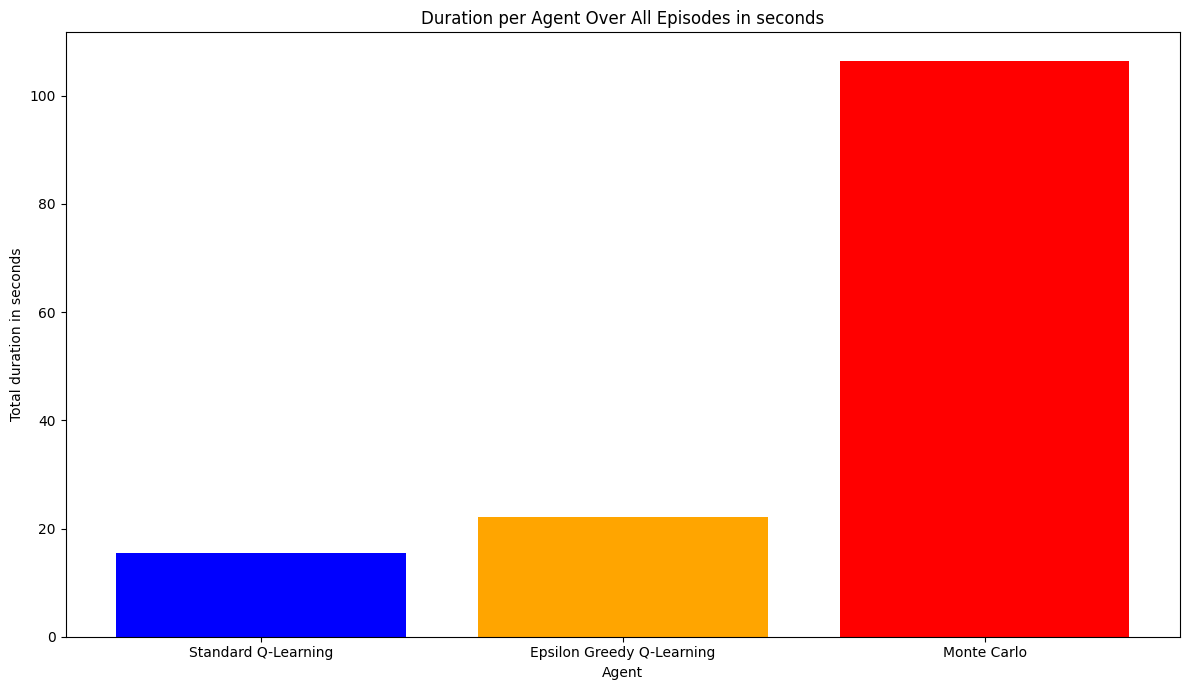

In [ ]:
agents = ['Standard Q-Learning','Epsilon Greedy Q-Learning', 'Monte Carlo']
total_rewards_per_agent = [
    np.sum(duration_q_learning_agent),
    np.sum(duration_q_learning_epsilon_greedy_agent),
    np.sum(duration_monte_carlo_agent)
]

# Plotting
plt.figure(figsize=(12, 7))  # Adjust the figure size as needed

# Create a bar plot
x_pos = np.arange(len(agents))
plt.bar(x_pos, total_rewards_per_agent, color=['blue', 'orange', 'red'])

plt.xticks(x_pos, agents)  # Rotate agent names for better visibility
plt.title('Duration per Agent Over All Episodes in seconds')
plt.xlabel('Agent')
plt.ylabel('Total duration in seconds')
plt.tight_layout()  # Automatically adjust subplot params to fit the figure
plt.show()

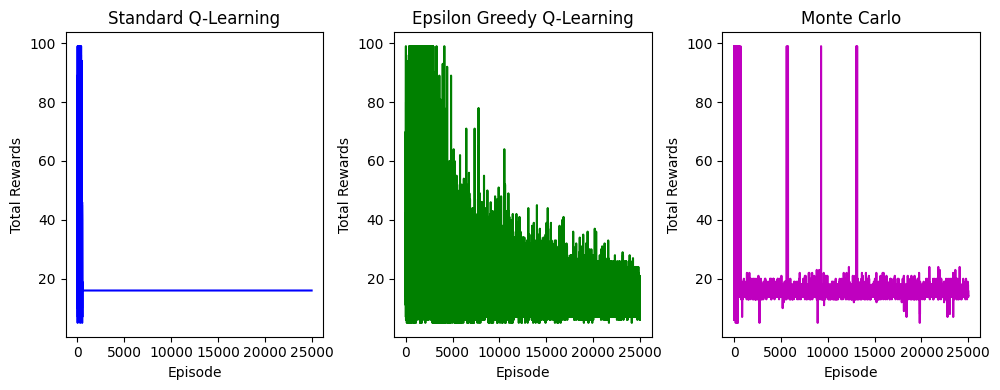

In [ ]:
# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 4))  # Square figure size

# Plotting each agent's total rewards per episode in its own subplot
axs[0].plot(q_learning_actions, 'b-')
axs[0].set_title('Standard Q-Learning')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Total Rewards')

axs[1].plot(q_learning_epsilon_greedy_actions, 'g-')
axs[1].set_title('Epsilon Greedy Q-Learning')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Total Rewards')

axs[2].plot(monte_carlo_agent_actions, 'm-')
axs[2].set_title('Monte Carlo')
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Total Rewards')

# Adding a tight layout to ensure no overlapping content
plt.tight_layout()

plt.show()

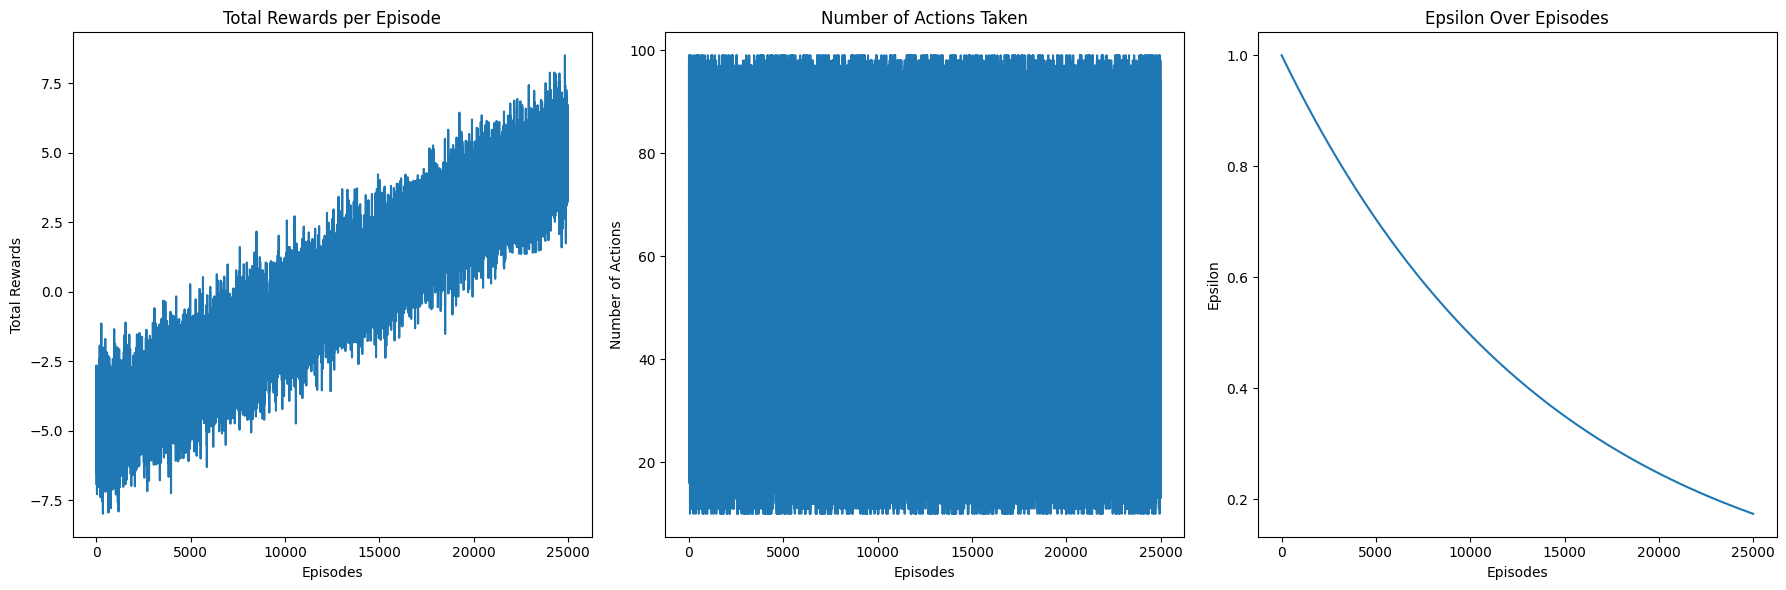

In [ ]:
plt.figure(figsize=(18, 6))

# Plot total rewards per episode
plt.subplot(1, 3, 1)
plt.plot(range(25000), q_learning_epsilon_greedy_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')

# Plot number of actions taken over episodes
plt.subplot(1, 3, 2)
plt.plot(range(25000), q_learning_epsilon_greedy_actions)
plt.title('Number of Actions Taken')
plt.xlabel('Episodes')
plt.ylabel('Number of Actions')

# Plot epsilon over episodes
plt.subplot(1, 3, 3)
plt.plot(range(25000), epsilons)
plt.title('Epsilon Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')

plt.tight_layout()
plt.show()

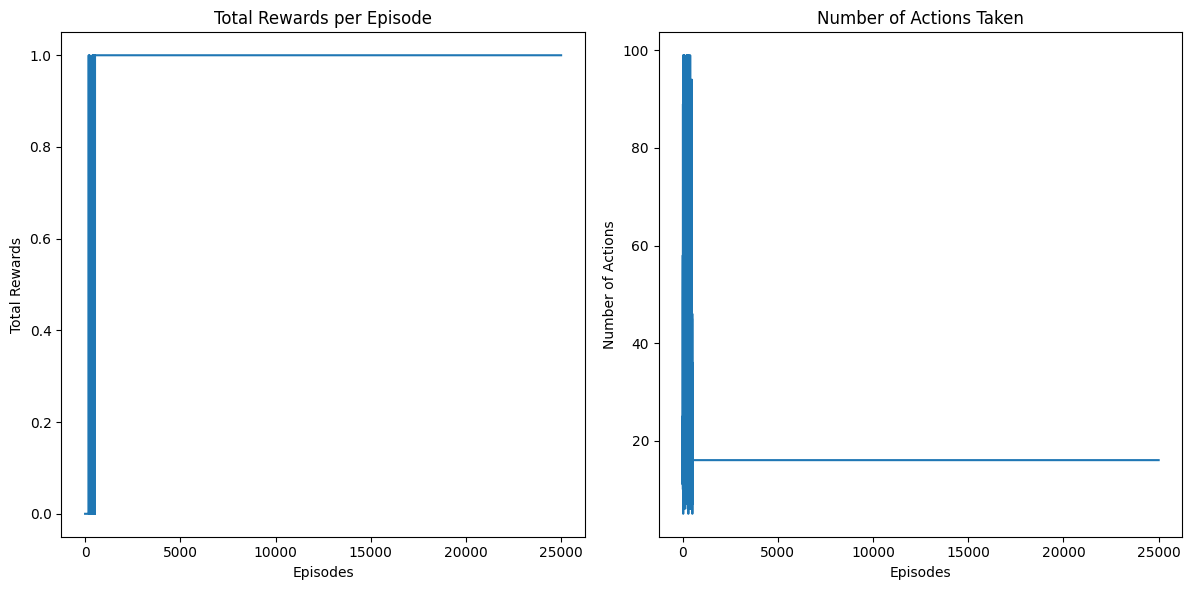

In [ ]:
plt.figure(figsize=(18, 6))

# Plot total rewards per episode
plt.subplot(1, 3, 1)
plt.plot(range(25000), q_learning_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')

# Plot number of actions taken over episodes
plt.subplot(1, 3, 2)
plt.plot(range(25000), q_learning_actions)
plt.title('Number of Actions Taken')
plt.xlabel('Episodes')
plt.ylabel('Number of Actions')


plt.tight_layout()
plt.show()

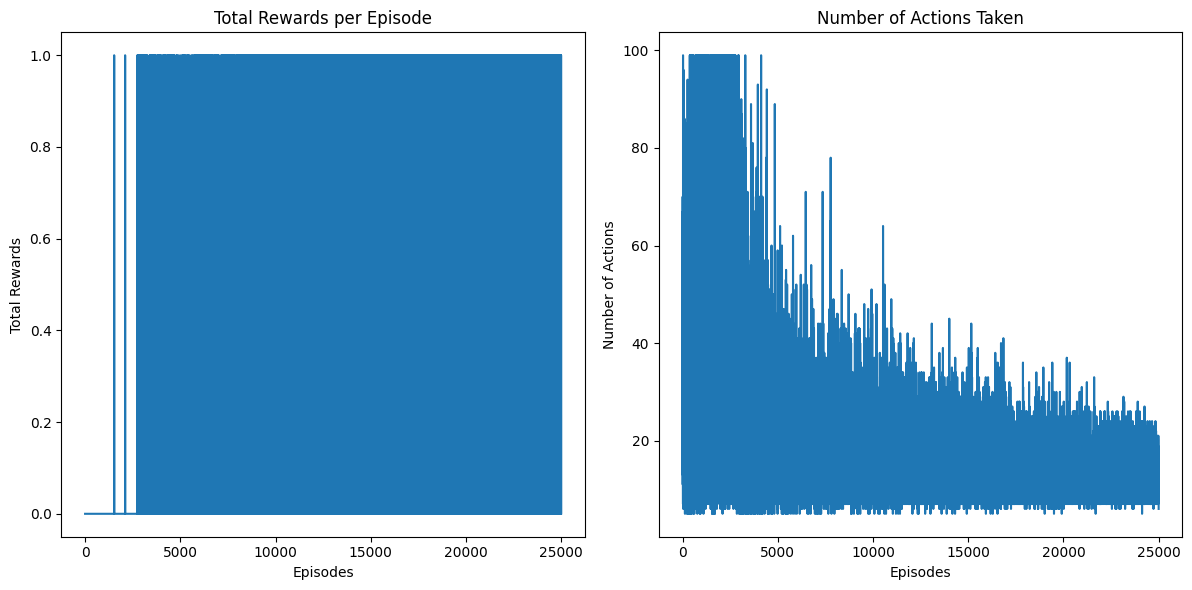

In [ ]:
plt.figure(figsize=(18, 6))

# Plot total rewards per episode
plt.subplot(1, 3, 1)
plt.plot(range(25000), q_learning_epsilon_greedy_rewards)
plt.title('Total Rewards per Episode')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')

# Plot number of actions taken over episodes
plt.subplot(1, 3, 2)
plt.plot(range(25000), q_learning_epsilon_greedy_actions)
plt.title('Number of Actions Taken')
plt.xlabel('Episodes')
plt.ylabel('Number of Actions')


plt.tight_layout()
plt.show()

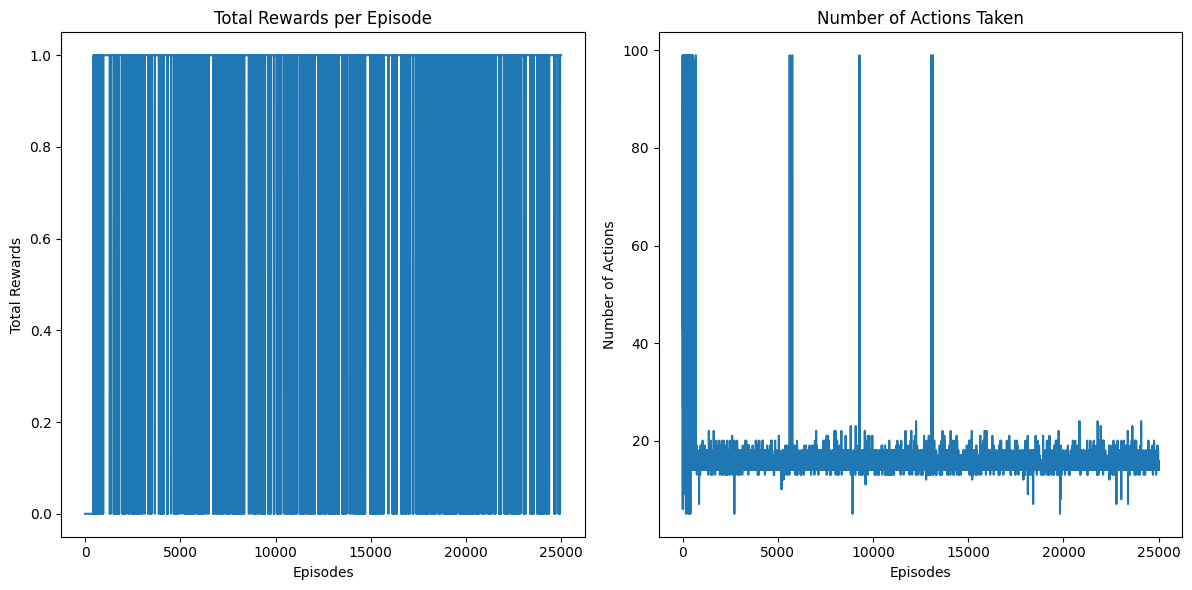

In [ ]:
plt.figure(figsize=(18, 6))

# Plot total rewards per episode
plt.subplot(1, 3, 1)
plt.plot(range(25000), monte_carlo_agent_reward)
plt.title('Total Rewards per Episode')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')

# Plot number of actions taken over episodes
plt.subplot(1, 3, 2)
plt.plot(range(25000), monte_carlo_agent_actions)
plt.title('Number of Actions Taken')
plt.xlabel('Episodes')
plt.ylabel('Number of Actions')


plt.tight_layout()
plt.show()

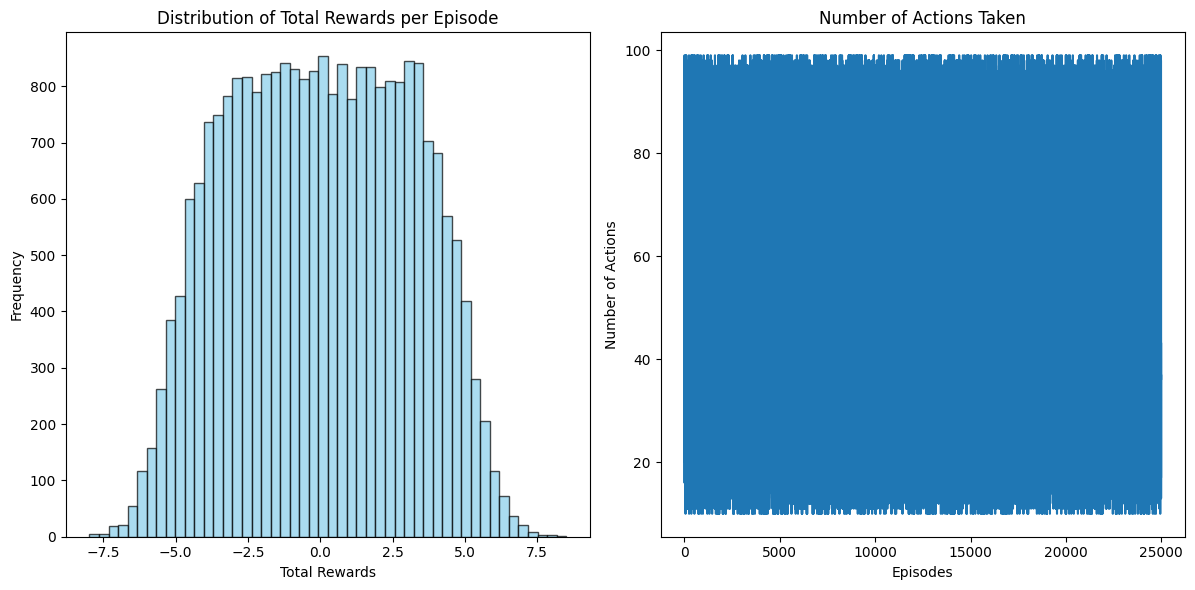

In [ ]:
plt.figure(figsize=(18, 6))

# Histogram for total rewards per episode
plt.subplot(1, 3, 1)
plt.hist(q_learning_epsilon_greedy_rewards, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Rewards per Episode')
plt.xlabel('Total Rewards')
plt.ylabel('Frequency')

# Keep the second subplot unchanged for consistency
plt.subplot(1, 3, 2)
plt.plot(episodes, q_learning_epsilon_greedy_actions)
plt.title('Number of Actions Taken')
plt.xlabel('Episodes')
plt.ylabel('Number of Actions')


plt.tight_layout()
plt.show()

In [ ]:
reward_rate_q_learning , action_per_episode_q_learning = evaluate_agent(env=env,q_table=q_learning_agent)
reward_rate_q_learning_epsilon_greedy , action_per_episode_q_learning_epsilon_greedy = evaluate_agent(env=env,q_table=q_learning_epsilon_greedy_agent)
reward_rate_monte_carlo, action_per_episode_monte_carlo = evaluate_agent(env=env,policy=monte_carlo_agent)


In [ ]:
print("Q-learning agent success rate: ", np.sum(reward_rate_q_learning))
print("Q-learning With Epsilon-Greedy agent: ", np.sum(reward_rate_q_learning_epsilon_greedy))
print("Monte Carlo success rate agent: ", np.sum(reward_rate_monte_carlo))

Q-learning agent success rate:  100.0
Q-learning With Epsilon-Greedy agent:  100.0
Monte Carlo success rate agent:  100.0


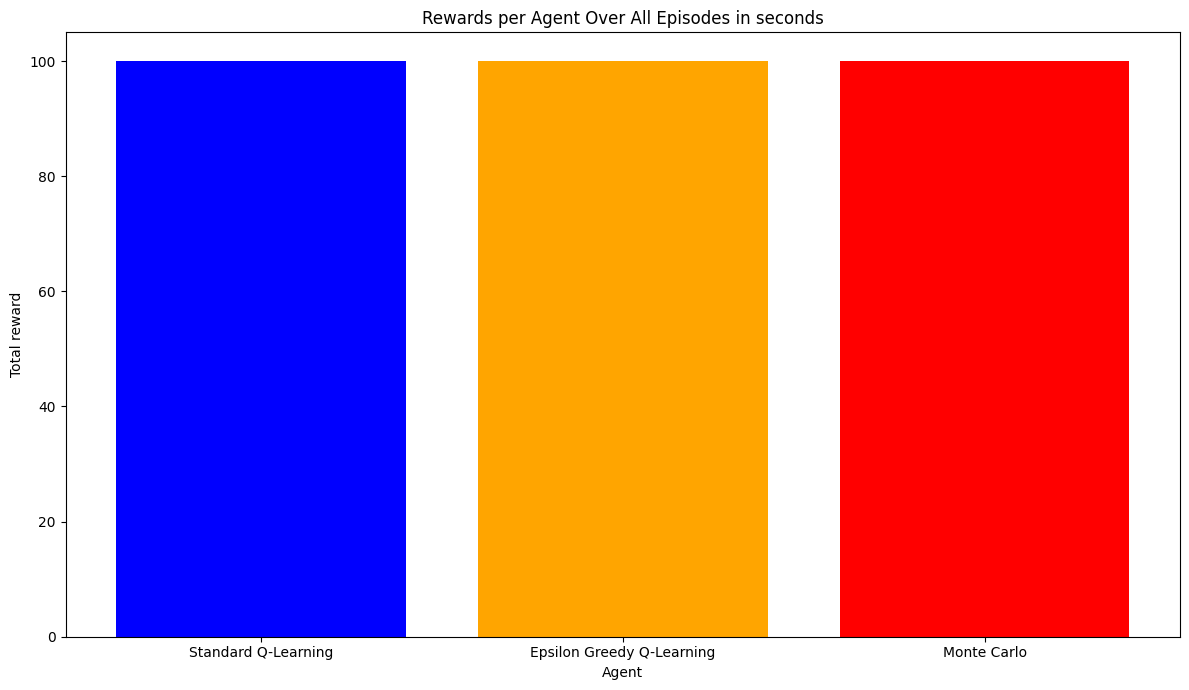

In [ ]:
agents = ['Standard Q-Learning','Epsilon Greedy Q-Learning', 'Monte Carlo']
total_rewards_per_agent = [
    np.sum(reward_rate_q_learning),
    np.sum(reward_rate_q_learning_epsilon_greedy),
    np.sum(reward_rate_monte_carlo)
]

# Plotting
plt.figure(figsize=(12, 7))  # Adjust the figure size as needed

# Create a bar plot
x_pos = np.arange(len(agents))
plt.bar(x_pos, total_rewards_per_agent, color=['blue', 'orange', 'red'])

plt.xticks(x_pos, agents)  # Rotate agent names for better visibility
plt.title('Rewards per Agent Over All Episodes in seconds')
plt.xlabel('Agent')
plt.ylabel('Total reward')
plt.tight_layout()  # Automatically adjust subplot params to fit the figure
plt.show()

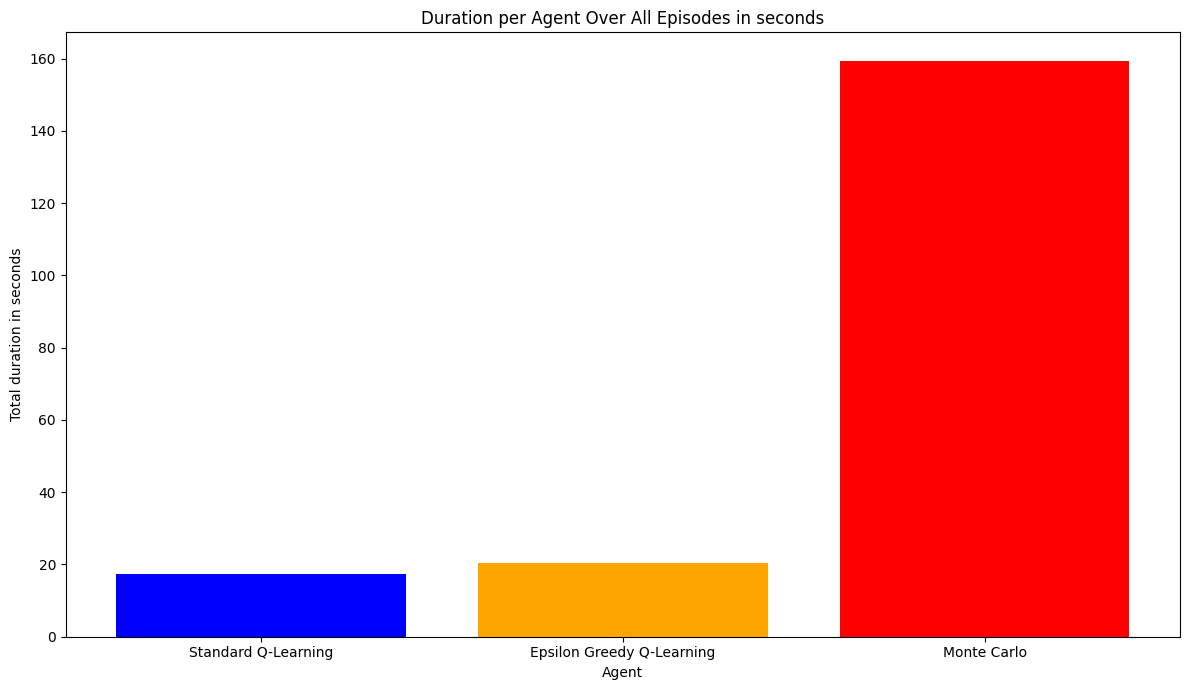

In [ ]:
agents = ['Standard Q-Learning','Epsilon Greedy Q-Learning', 'Monte Carlo']
total_rewards_per_agent = [
    np.sum(duration_q_learning_agent),
    np.sum(duration_q_learning_epsilon_greedy_agent),
    np.sum(duration_monte_carlo_agent)
]

# Plotting
plt.figure(figsize=(12, 7))  # Adjust the figure size as needed

# Create a bar plot
x_pos = np.arange(len(agents))
plt.bar(x_pos, total_rewards_per_agent, color=['blue', 'orange', 'red'])

plt.xticks(x_pos, agents)  # Rotate agent names for better visibility
plt.title('Duration per Agent Over All Episodes in seconds')
plt.xlabel('Agent')
plt.ylabel('Total duration in seconds')
plt.tight_layout()  # Automatically adjust subplot params to fit the figure
plt.show()

# 16x16 Grid size Frozen Lake

In [ ]:
from gym.envs.toy_text.frozen_lake import generate_random_map
random_map = [
    'SFFFFFFFFFFFFFFH',
    'FFFFFFFFFFFFFFFF',
    'FFFFFFFFFFFFFFFF',
    'FFFFFFFFFFFFFFFH',
    'FFFFFFFFFFFFFFFF',
    'FFFFFFFFFFHFFFFF',
    'FFFFFFFFFFFHFFFF',
    'FFFFFFFFFFFHFFFF',
    'FFFFHHFFFFFFFFFF',
    'FFFFFFFFFHFFFFFF',
    'FFFFFFFFFHFFFFFF',
    'FFFFFFFFFFFFFFFF',
    'HFFFFFFHFFFHFFFH',
    'FHFFFFFFFHFFFFFF',
    'FHFFHFFFFFFFFFFF',
    'FFHFFFFFFFFFFFFG'
]
env = gym.make('FrozenLake-v1',desc=random_map, is_slippery=False)
action_size = env.action_space.n
print("Action size: ", action_size)

state_size = env.observation_space.n
print("State size: ", state_size)

In [ ]:
frozen_lake_map = env.spec.kwargs

for row in frozen_lake_map['desc']:
    print(row)

**Q-learning agent**

In [ ]:
q_learning_agent_start_time = time.time()
q_learning_agent, q_learning_rewards, q_learning_actions, q_learning_paths = q_learning(
    env=env,
    total_episodes=500000,
    learning_rate=0.001,
    max_steps=500,
    discount_rate=0.9
)
duration_q_learning_agent = time.time() - q_learning_agent_start_time
print("Duration time for q_learning_agent = ",duration_q_learning_agent," seconds")
print(np.sum(q_learning_rewards))

In [ ]:
print("Success rate learning = ", (np.sum(q_learning_rewards) / 5000000) * 100,"%")

q_learning_unique_path_number = len(set(tuple(path) for path in q_learning_paths))
print("Number of different paths",q_learning_unique_path_number)

print("Q-learning avg nr actions: ", np.mean(q_learning_actions))

reward_rate_q_learning , action_per_episode_q_learning = evaluate_agent(env=env,q_table=q_learning_agent)
print("Q-learning agent success rate: ", np.sum(reward_rate_q_learning))

Success rate learning =  59.768 %
Number of different paths 80548
Q-learning avg nr actions:  21.722042
Q-learning agent success rate:  100.0


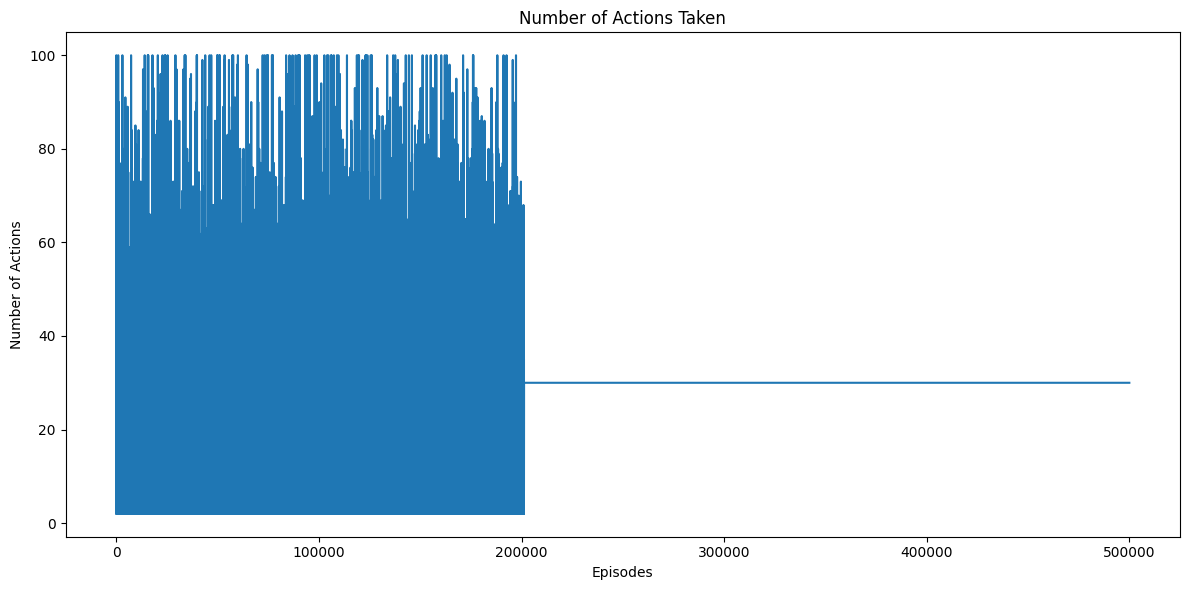

In [ ]:
plt.figure(figsize=(12, 6))


plt.plot(range(500000), q_learning_actions, label='Actions')
plt.title('Number of Actions Taken')
plt.xlabel('Episodes')
plt.ylabel('Number of Actions')


plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

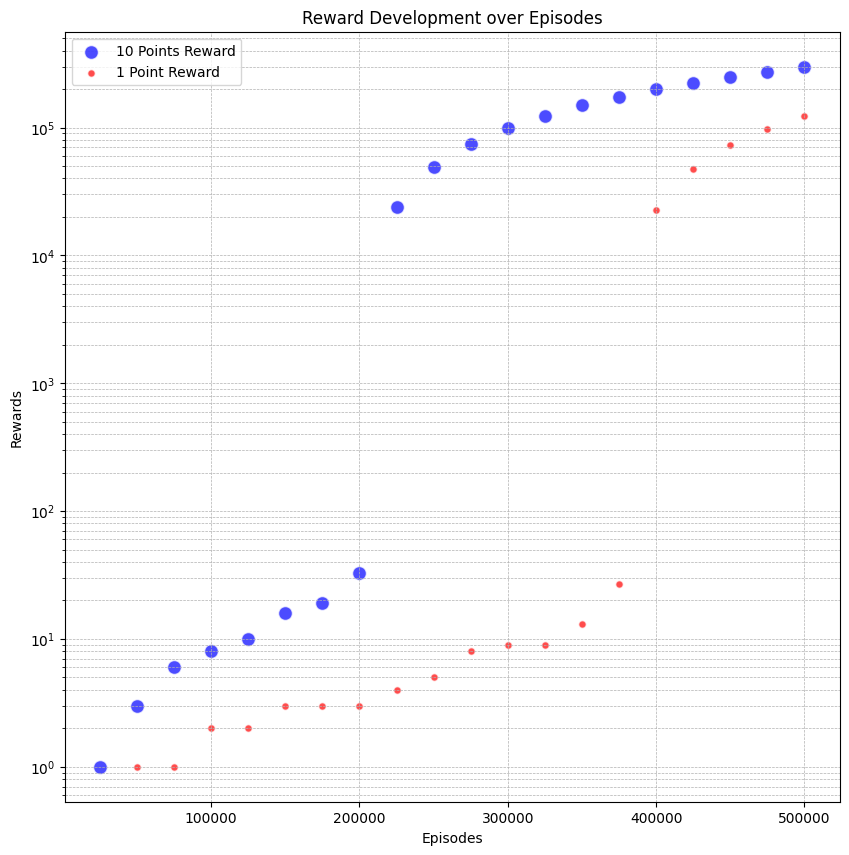

In [ ]:
episodes = list(range(25000, 500001, 25000))
rewards_10_points = [
    1, 3, 6, 8, 10, 16, 19, 33, 23841, 48841, 73841, 98841, 123841, 148841,
    173841, 198841, 223841, 248841, 273841, 298840
]
rewards_1_point = [
    0, 1, 1, 2, 2, 3, 3, 3, 4, 5, 8, 9, 9, 13, 27, 22717, 47717, 72717, 97717,
    122716
]

# Creating a DataFrame
data = pd.DataFrame({
    "Episodes": episodes,
    "10 Points Reward": rewards_10_points,
    "1 Point Reward": rewards_1_point
})


plt.figure(figsize=(10, 10))

# Plotting both rewards with distinct colors and markers
plt.scatter(data["Episodes"], data["10 Points Reward"], color="blue", alpha=0.7, s=100, label="10 Points Reward", edgecolors="w")
plt.scatter(data["Episodes"], data["1 Point Reward"], color="red", alpha=0.7, s=30, label="1 Point Reward", edgecolors="w")

# Enhancements for visualization
plt.title("Reward Development over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.yscale('log') # Applying logarithmic scale to better visualize lower rewards
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.show

**Q_learning_epsilon_greedy agent**

In [ ]:
q_learning_epsilon_greedy_agent_start_time = time.time()

q_learning_epsilon_greedy_agent, q_learning_epsilon_greedy_rewards, q_learning_epsilon_greedy_actions, epsilons, q_learning_epsilon_greedy_paths = q_learning_epsilon_greedy(
    env=env,
    total_episodes=500000,
    max_steps=250,
    learning_rate=0.001,
    gamma=0.9,
    min_epsilon=0.001,
    max_epsilon=1.0,
    decay_rate=0.0000005
)
duration_q_learning_epsilon_greedy_agent = time.time() - q_learning_epsilon_greedy_agent_start_time
print("Duration time for q_learning_epsilon_greedy_agent = ",duration_q_learning_epsilon_greedy_agent," seconds")
print(np.sum(q_learning_epsilon_greedy_rewards))
print(np.argmax(q_learning_epsilon_greedy_agent))


In [ ]:
print("Success rate learning = ", ((np.sum(q_learning_epsilon_greedy_rewards) / 500000)) * 10,"%")

q_learning_unique_path_number = len(set(tuple(path) for path in q_learning_epsilon_greedy_paths))
print("Number of different paths",q_learning_unique_path_number)

print("Q-learning avg nr actions: ", np.mean(q_learning_epsilon_greedy_actions))

reward_rate_q_learning , action_per_episode_q_learning = evaluate_agent(env=env,q_table=q_learning_epsilon_greedy_agent)
print("Q-learning agent success rate: ", np.sum(reward_rate_q_learning))

Success rate learning =  27.2434 %
Number of different paths 488386
Q-learning avg nr actions:  74.886274
Q-learning agent success rate:  100.0


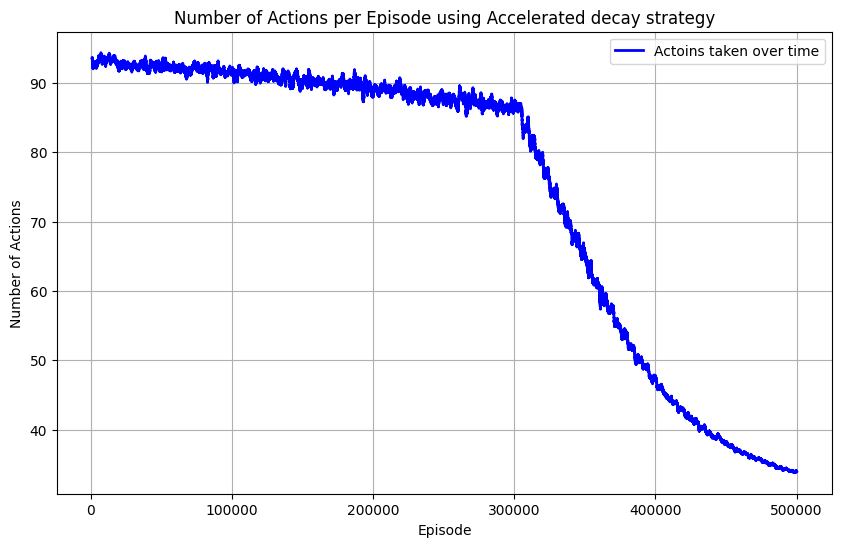

In [ ]:
np.random.seed(0)  # For reproducibility
# Create dataframe
data_epsilon_greedy = pd.DataFrame({
    'Episode': np.arange(1, 500001),
    'Number_of_Actions': q_learning_epsilon_greedy_actions
})

# Calculate moving average
window_size = 1000  # Adjust the window size as needed
data_epsilon_greedy['Moving_Average'] = data_epsilon_greedy['Number_of_Actions'].rolling(window=window_size).mean()

# Plot for epsilon-greedy with moving average
plt.figure(figsize=(10, 6))
plt.plot(data_epsilon_greedy['Episode'], data_epsilon_greedy['Moving_Average'], color='blue', linewidth=2, label=f'Actoins taken over time')
plt.title('Number of Actions per Episode using Accelerated decay strategy')
plt.xlabel('Episode')
plt.ylabel('Number of Actions')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
episodes = list(range(25000, 500001, 25000))
rewards_10_points = [
    1, 3, 6, 8, 10, 16, 19, 33, 23841, 48841, 73841, 98841, 123841, 148841,
    173841, 198841, 223841, 248841, 273841, 298840
]
rewards_1_point = [
    3, 8, 21, 36, 56, 81, 121, 187, 267, 358, 492, 661, 896, 1155, 1512, 1971, 2549, 3268, 4150, 5221.0
]

# Creating a DataFrame
data = pd.DataFrame({
    "Episodes": episodes,
    "10 Points Reward": rewards_10_points,
    "1 Point Reward": rewards_1_point
})


plt.figure(figsize=(10, 10))

# Plotting both rewards with distinct colors and markers
plt.scatter(data["Episodes"], data["10 Points Reward"], color="blue", alpha=0.7, s=100, label="10 Points Reward", edgecolors="w")
plt.scatter(data["Episodes"], data["1 Point Reward"], color="red", alpha=0.7, s=30, label="1 Point Reward", edgecolors="w")

# Enhancements for visualization
plt.title("Reward Development over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.yscale('log') # Applying logarithmic scale to better visualize lower rewards
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.show

**Monte Carlo**

In [ ]:
monte_carlo_agent_start_time = time.time()
monte_carlo_agent, monte_carlo_agent_reward, monte_carlo_agent_actions, monte_carlo_agent_paths = monte_carlo_e_soft(env, max_steps=250, episodes=500000, epsilon=0.1)
duration_monte_carlo_agent = time.time() - monte_carlo_agent_start_time
print("Duration time for monte_carlo_agent_start_time = ",duration_monte_carlo_agent," seconds")
print(np.sum(monte_carlo_agent_reward))
print(np.argmax(monte_carlo_agent))